<a href="https://colab.research.google.com/github/Mattobad/Pneumonia-Detection-Deep-Learning/blob/master/End_to_End_Pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## End to End image classification for Pneumonia Detection using X-ray Images

The main motive of starting this project is to build Deep Learning(DL) model to detect presence of pnuemonia provided the patient X-rays images or patient DICOM(Digital Imaging and Communications in Medicine) file. And later on use the trained model to be deployed as web application using docker and flask-python(initial model deployment and later going to exploring other different possibilities) where user can provide X-ray image or DICOM file and see what model predicts. 

In this notebook, we're going to implement end to end Binary image classification(supervised learning) to detect pneumonia in the x-ray images using Tensorflow-keras. We are going to also look into different model architecture(play around with different architecture), optimization hypermeters.

###### 1. Problem
To detect the traces of pneumonia in the x-ray images.

###### 2. Data
The data was taken from Kaggle's Pneumonia detection challenge. [Link to the data](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data)

###### 3. Evaluation
Evaluation metric used here is accuracy(how well the model predicted value correspondes with the original value).


**Note:** Model build here is for learning purpose only and not applicable for real case scenario where serious decision is to be made.

Happy Learning!!!

In [ ]:
# process to unzip the file
#!unzip "drive/My Drive/Data/rsna-pneumonia-detection-challenge.zip" -d "drive/My Drive/Data/pneumonia-data"

##### 1. Making your workspace ready.

In [ ]:
# Import TF 2.x
try:
  # %tensorflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)

print("TF HUB version:", hub.__version__)
#Check for GPU availability
print("GPU","available (YESS!!)" if tf.config.list_physical_devices("GPU") else "GPU not available")

TF version: 2.2.0
TF HUB version: 0.8.0
GPU available (YESS!!)


In [3]:
# install the pydicom module as required for patient data
# pypng for converting image pixel into images files(png)
!pip install pydicom pypng

     |████████████████████████████████| 35.5MB 88kB/s 
     |████████████████████████████████| 655kB 40.3MB/s 
  Created wheel for pypng: filename=pypng-0.0.20-cp36-none-any.whl size=67161 sha256=f14fa4b866ec58ed820ea3209d858066b88b32ae7fb87cd3d1c8417e8dfec4e5
  Stored in directory: /root/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
Successfully built pypng


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom 

labels_csv = pd.read_csv('drive/My Drive/Data/pneumonia-data/stage_2_train_labels.csv')
print(labels_csv.describe())
labels_csv.head(2)

                 x            y        width       height        Target
count  9555.000000  9555.000000  9555.000000  9555.000000  30227.000000
mean    394.047724   366.839560   218.471376   329.269702      0.316108
std     204.574172   148.940488    59.289475   157.750755      0.464963
min       2.000000     2.000000    40.000000    45.000000      0.000000
25%     207.000000   249.000000   177.000000   203.000000      0.000000
50%     324.000000   365.000000   217.000000   298.000000      0.000000
75%     594.000000   478.500000   259.000000   438.000000      1.000000
max     835.000000   881.000000   528.000000   942.000000      1.000000


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0


In [ ]:
labels_csv[labels_csv['Target'] == 1][:1] 

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


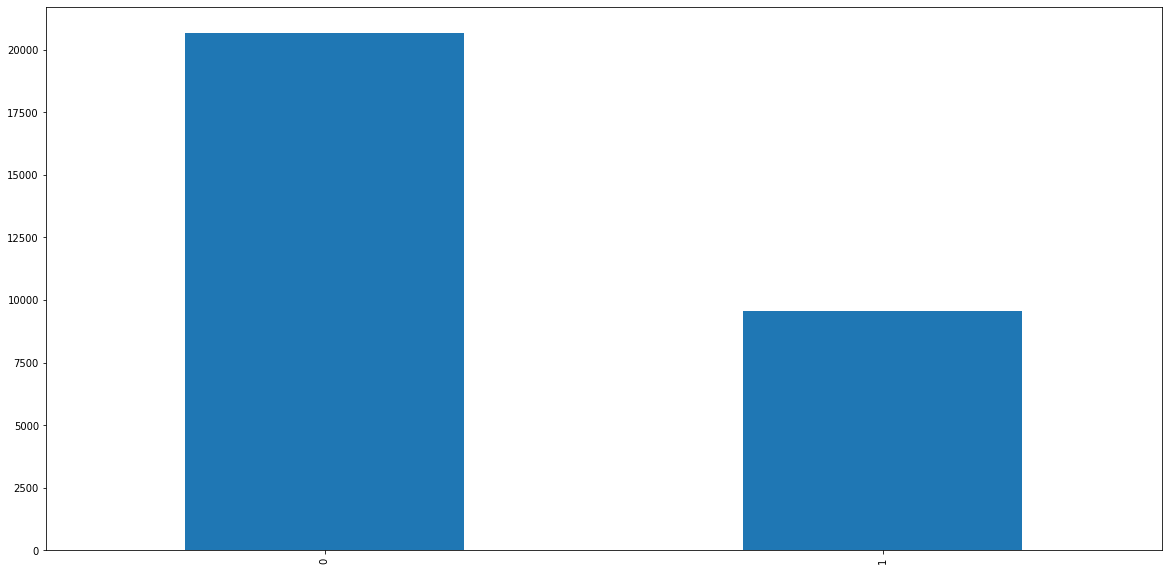

In [ ]:
labels_csv.Target.value_counts().plot.bar(figsize=(20,10))

In [ ]:
labels_csv['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

So,there are 20672 record of patient without pneumonia and 9555 record of patient with pneumonia

##### 2. Understanding the DICOM(Digital Imaging and Communications in Medicine) files

Dicom files consists of all the metadata related to patient includeing images. Python library pydicom is used here for exploring the dicom files.

In [ ]:
# to read the first patient ID
patientId = labels_csv['patientId'][0]
dcm_file = 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)
#0004cfab-14fd-4e49-80ba-63a80b6bddd6
print()
print(dcm_data["PatientID"])
print()
print()
print()
# check the patient age and sex related specific patient id
print(dcm_data['PatientAge'][:3])
print(dcm_data['PatientSex'][0])

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
# function to display images
import pylab
def display_image(f):
  # dcm_data = pydicom.read_file(f)
  # im = dcm_data.pixel_array
  im = image_pixel(f)
  pylab.imshow(im, cmap=pylab.cm.gist_gray)
  pylab.axis('off')


# function to return image pixel
def image_pixel(file_name):
  dcm_data = pydicom.read_file(file_name)
  img_pixel = dcm_data.pixel_array
  return img_pixel

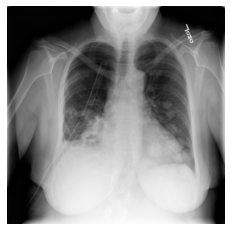

In [ ]:
display_image(dcm_file)

In [ ]:
# create pathnames from dicom files
filenames = ['drive/My Drive/Data/pneumonia-data/stage_2_train_images/'+fname+'.dcm' for fname in labels_csv['patientId']]
print(len(filenames))
#check the first 10
filenames[:10]


30227


['drive/My Drive/Data/pneumonia-data/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00322d4d-1c29-4943-afc9-b6754be640eb.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00569f44-917d-4c86-a842-81832af98c30.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/006cec2e-6ce2-4549-bffa-eadfcd1e9970.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00704310-78a8-4b38-8475-49f4573b2dbb.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00704310-78a8-4b38-8475-49f4573b2

In [ ]:
# import os

# path_to_test = "drive/My Drive/Data/pneumonia-data/stage_2_train_images/"
# # test for file path to get the file name from the directory
# files_with_id = [f for f in os.listdir(path_to_test) if f.endswith('.dcm')]
# files_with_id[:2]

['fbea2dbf-3828-4b0b-a8cf-e1a1e513851b.dcm',
 'fc3759df-79a4-41f1-a461-a2d12f09f489.dcm']

[[255 203 114 ...   9   9   9]
 [233 160  96 ...  12  12  12]
 [180 105  75 ...  12  12  12]
 ...
 [160 167 158 ... 103 104 105]
 [179 166 161 ... 106 104 102]
 [204 170 166 ... 110 110 109]]


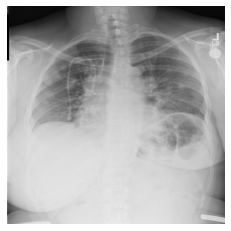

In [ ]:
# testing if the display function for image works
image = image_pixel(filenames[500])
print(image)
display_image(filenames[500])

In [ ]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir('drive/My Drive/Data/pneumonia-data/stage_2_train_images/')) == len(filenames):
  print('Filenames match the actual file length!!')
else:
  print('Filenames doesn\'t match the acutal file length')

print(len(os.listdir('drive/My Drive/Data/pneumonia-data/stage_2_train_images/')),len(filenames))



Filenames doesn't match the acutal file length
26684 30227


In [ ]:
print(len(labels_csv))
# number of unique patientId
print("Number of unique patient {}".format(len(np.unique(labels_csv['patientId']))))

30227
Number of unique patient 26684


Number of images doesn't match the number of files of patientID which means all the dicom files of the patient is not in the dataset. There are 26684 train dicom files and 3000 test dicom files which doesn't sum up to 30227(total was 29684 combining both train and test). But while looking for unique patientId found there were only 26684 unique patient. Some patient have more than one records.

###### Section for EDA(Exploratory Data Analysis)

In this particular section, we're going to extract the metadata of the patient like Patient Sex, Age and other useful resources to analysis the data and get to know who are mainly affected by pneumonia. Final step is to extract the pixel values, convert them to image format to get ready to feed into Neural Network. 


[link for the function taken for the following code](https://github.com/ajsanjoaquin/COVID-19-Scanner/blob/master/covidtesting_notebook(Resnet34).ipynb)

In [ ]:
# function to get the metadata and convert pixel to image format(png)
import os
import pydicom
from png import Writer


# function to get dicom file
def read_dicom(file_name,source_path):
  """
  Function that reads the dicom file and returns the dicom datasets

  Args:
    file_name: dicom file name related to patient

  Returns:
    dicom dataset of the particular patient
  """
  # handling error for file not found
  try:
    ds = pydicom.dcmread(source_path+'/'+file_name+'.dcm')
    return ds
  except:
    return print('file not found!!!')

# function to get metadata of patient from dicom files
def get_metadata(file_name,s_path):
  """
  Function to return metadata(patient age & sex) required

  Args:
    file_name: dicom file name
  Returns:
    list containing patient data
  """
  # incase of file not found: returns no object
  try:
    ds = read_dicom(file_name,s_path)
    # list to carry patient info
    patient_info = []
    # dicom age element was in str and below slice is used only to take the age of
    # patient. i.e single character is represented by single digit
    #print('Patient age = {0} & sex ={1}'.format(ds["PatientAge"][:3],ds["PatientSex"][0]))
    patient_age = ds["PatientAge"][:3]
    patient_sex = ds["PatientSex"][0]
    # adding patient age and sex into to list
    patient_info = [patient_age,patient_sex]
    # returning the list containing patient info
    return patient_info
  except: 
    patient_info =[np.NaN,np.NaN]
    return patient_info



def dicom_to_png(source_path,dist_path,file_name):
  """
  Function returns metadata(Patient sex, age) and additionally 
  converts the pixel into image format and to folder 

  Args:
    source_path: files source directory
    attribute: metadata in dicom file of the patient
  
  Returns:
    metadata related to patient
  """

  # incase no file found: returns null object
  try:
    # read and parse using read_dicom function
    ds = read_dicom(file_name,source_path)
    # for image pixel to image format
    shape = ds.pixel_array.shape
    # Convert to float to avoid overflow or underflow losses
    image_2d = ds.pixel_array.astype('float32')

    # Rescaling grey scale between 0-255
    image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0

    # convert to uint
    image_2d_scaled = np.uint8(image_2d_scaled)
  except:
    return print('No file to write..')
  
  try:
    # patient id for the image file name as required by later process
    #file_name = ds["PatientID"]

    # Write the PNG file
    with open(os.path.join(dist_path,file_name+'.png'),'wb') as png_file:
      #print('Converting pixel to image started..')
      w = Writer(shape[1],shape[0],greyscale=True)
      w.write(png_file,image_2d_scaled)
      #print('Conversion finished..')
  except:
    # use proper exception msg
    return print('Errro while writing the file!!!')
 

In [ ]:
# create pathnames from dicom files
patients_id = [fname for fname in labels_csv['patientId']]
print(len(patients_id))
print(len(np.unique(patients_id)))
# removing duplicates from the patient file
patients_id = np.unique(patients_id)
print(patients_id[:1][0])
print(type(patients_id[:1][0]))
#check the first 10
patients_id[:10]

30227
26684
0004cfab-14fd-4e49-80ba-63a80b6bddd6
<class 'numpy.str_'>


array(['0004cfab-14fd-4e49-80ba-63a80b6bddd6',
       '000924cf-0f8d-42bd-9158-1af53881a557',
       '000db696-cf54-4385-b10b-6b16fbb3f985',
       '000fe35a-2649-43d4-b027-e67796d412e0',
       '001031d9-f904-4a23-b3e5-2c088acd19c6',
       '0010f549-b242-4e94-87a8-57d79de215fc',
       '001916b8-3d30-4935-a5d1-8eaddb1646cd',
       '0022073f-cec8-42ec-ab5f-bc2314649235',
       '0022995a-45eb-4cfa-9a59-cd15f5196c64',
       '0025d2de-bd78-4d36-9f72-e15a5e22ca82'], dtype='<U36')

In [ ]:
# lets test the conversion function with one image

# common path(main)
path = "drive/My Drive/Data/pneumonia-data"
# source path
s_path =os.path.join(path,"stage_2_train_images")
# destination path
des_path =os.path.join(path,"train")

result = dicom_to_png_metadata(s_path,des_path,patient_id[:1][0])
result

Converting pixel to image started..
Conversion finished..
Patient age = 51 & sex =F


['51', 'F']

In [ ]:
# demo function to implement the function to make a dataFrame from patient info

# this particular cell gives basic idea  
#how the patient dataFrame is being created below
def test_fun(id):
  if id == 3:
    return ['hello','world']
  else:
    return ['you','know what']

test_df = pd.DataFrame(columns=['Id','first','Name'])
test_df['Id'] = [1,2,3,4,5]

# first = test_df['Id'].apply(lambda x: test_fun(x))
# for id in range(len(test_df)):
#   print(id)
#   test_df.loc[test_df['Id']==id,'first'] = first[id][0]

for id in test_df['Id']:
  #print(id)
  # temp = test_df['Id'].apply(lambda x: test_fun(x))
  temp = test_fun(id)
  test_df.loc[test_df['Id'] == id,'first'] = temp[0]
  test_df.loc[test_df['Id'] == id,'Name'] = temp[1]

test_df

,Id,first,Name
0,1,you,know what
1,2,you,know what
2,3,hello,world
3,4,you,know what
4,5,you,know what


In [ ]:
# make sure the sample you're taking for training the DL model has
# equal number of both of the classes. In our case, equal number of 
# X-ray images both normal and pneumonia patient..

# for this case, I'll be using stratified sampling technique.
# As there are 9555 cases of pneunomia, so we're going to take
# 9555 case of normal X-rays of patient. It simple in our case,
# take 9555 normal cases plus the pnuemonia cases.
# shuffling is taken care while seperating the data into training and validation
# set

# pneumonia patient
pneumonia_patient = labels_csv.loc[labels_csv['Target'] ==1,'patientId']
print(type(pneumonia_patient))
print(len(pneumonia_patient))
#print(pneumonia_patient['Target'].value_counts())

# normal patient
normal_patient = labels_csv.loc[labels_csv['Target'] ==0,'patientId'][:13000]
print(type(normal_patient))
print(len(normal_patient))
#normal_patient['Target'].value_counts()

# selecting data with only 9555 normal and 9555 pneumonia cases and save 
# patient id into a list for later use
patients_list = pneumonia_patient.append(normal_patient)
print(type(patients_list))

patients_list = np.unique(patients_list).tolist()
print(len(patients_list))
type(patients_list)

<class 'pandas.core.series.Series'>
9555
<class 'pandas.core.series.Series'>
13000
<class 'pandas.core.series.Series'>
19012


list

As there is whole lot of image files to be created (which requires more than two hour if you tried to convert the files). So, we're only going to take only 1000 files(50% each classes) to feed them into DL model(as it is computationaly heavy to train the model on whole dataset). Because the main idea is to build working DL model to be deployed not accuracy here: for the learning purpose.

In [ ]:
# custom value_counts for given list machanism
test_y =[1,1,1,1,1,0,0,0,0,0,0,0,1,1,4,4,5,5,5,2,2]

val_count = dict()
for val in test_y:
  if val not in val_count:
    val_count[val] =1
  else:
    val_count[val] +=1

val_count

{0: 7, 1: 7, 2: 2, 4: 2, 5: 3}

In [6]:
# lets implement the value_counts of pandas using custom 
# function for any given list
def list_value_counts(l):
  """
  Function returns dict containing the keys as values and values as counts
  for given list

  Args:
    l: given list
  Returns:
    dictionary containing value counts of the list
  """

  # creating empty dictionary
  val_count = dict()
  # looping over the elements of the list
  for item in l:
    if item not in val_count:
      val_count[item] =1
    else:
      val_count[item] +=1

  return val_count

In [7]:
# Set number of images to use for experimenting
NUM = 5000 #@param {type:"slider",min:4000,max:15000,step:1000}

In [8]:
# we are using scikit-learn to divide the train and valid sets
from sklearn.model_selection import train_test_split

X = labels_csv.drop('Target',axis=1)
y = labels_csv['Target']

print(X.shape,y.shape)

# train:valid (80:20) ratio with shuffle and 
# random state 42(for recreating the event) with 5000 datasets
X_train,X_valid,y_train,y_valid = train_test_split(X[:NUM],y[:NUM],
                                                   test_size=0.2,
                                                   random_state=42)

# check classes in each datasets
print(list_value_counts(y_train),list_value_counts(y_valid))

(30227, 5) (30227,)
{0: 2093, 1: 1907} {1: 460, 0: 540}


As you can see, there is 186 more normal data(patient without pneumonia) in training set and 80 more in validation set. Cause, we're trying to train with fewer datasets, this difference is larger which can result in biased model(even though we're trying to training a DL model with 4000 data which small for this Neural Network). All we're trying to do is, minimize all sorts of difficulties which is going to effect models accuracy.

Let's see if the following process shows any difference.

In [ ]:
print(len(labels_csv[labels_csv['Target']==1]))
labels_csv['Target'].value_counts()[1]

9555


9555

In [9]:
# take equal number of both the classes then split the dataset

# total pnuemonia patient in our dataset
NUM_PNUE = len(labels_csv[labels_csv['Target']==1])
# noraml patient with number of pnuemonia data
normal_df = labels_csv.loc[labels_csv['Target']==0][:NUM_PNUE]
print(normal_df.shape)
#pnuemonia patient
pnuemonia_df = labels_csv.loc[labels_csv['Target'] ==1]
print(pnuemonia_df.shape)
# combine both the dataFrame, default is concat vertically(by index)
combined_df = pd.concat([pnuemonia_df,normal_df],ignore_index=True)
print(combined_df.shape)

(9555, 6)
(9555, 6)
(19110, 6)


In [10]:
# we are using scikit-learn to divide the train and valid sets
from sklearn.model_selection import train_test_split


# we need shuffled data, so we're using sample from pandas
# using frac=0.3 gives best result for our target classes
df = combined_df.sample(frac=0.28,random_state=42)
print(df['Target'].value_counts())
print()
X = df.drop('Target',axis=1)
y = df['Target']

print(X.shape,y.shape)

# train:valid (80:20) ratio with shuffle and 
# random state 42(for recreating the event) with 5000 datasets
X_train,X_valid,y_train,y_valid = train_test_split(X[:NUM],y[:NUM],
                                                   test_size=0.2,
                                                   random_state=42)

# check classes in each datasets
print(list_value_counts(y_train),list_value_counts(y_valid))

1    2687
0    2664
Name: Target, dtype: int64

(5351, 5) (5351,)
{1: 2004, 0: 1996} {1: 504, 0: 496}


So, our experiment worked for this purpose. We can see there are 8 more pnuemonia class in both training and validation sets. Now let's carry on the next step on process. 

Converting the files ...

In [ ]:
#attribute list
#attributes = ['Patient_sex','Patient_age']
import pandas as pd
import os
#Q. code to test the conversion function and save the user metadata into csv file
 # 1. create a dataFrame with patient id using files_with_id list
 # 2. call the conversion function (dicom_to_png_metadata) and store the
 # return list into file(loop through all the files using apply method)
 # 3. store the result list into the dataFrame

def patient_data_tocsv(source_path,destination_path,patient_files):
  """
  Function that takes calls the another function to convert the image pixel 
  into images and outputs csv file with patient info from the patient dataFrame

  Args:
    source_path = directory containing dicom files
    destination_path = directory to holder the converted image files
    patient_files = list containing patient id

  Returns:
    doesn't return anything, only outputs csv file with patient record
  """
  # creating dataFrame with patient info column
  cols =['Patient_Id','Age','Sex']
  # creating empty dataframe with only columns name
  patient_df = pd.DataFrame(columns=cols)
  # enter data with patient
  patient_df['Patient_Id'] = patient_files

  print('Process started...')
  
  # counter to keep track of conversion file
  counter = 0
  # fraction to display prompt for user once certain conversion is reached..
  fraction =1/4

  # patient_id is the list consisting of all the file names
  for patient_id in patient_files:
    if len(patient_files) * fraction == counter: 
      print("{} of data out of 1".format(fraction))
      print("Handling file {} out of {}".format(counter,len(patient_files)))
      # next fraction is quarter higher
      fraction +=1/4

    # calling function to get the meta data
    result = get_metadata(patient_id,source_path)
    #print(type(result))
    #print(result)
    # calling function to convert the image  
    dicom_to_png(source_path,destination_path,patient_id)

    # fills the age and sex column related to the patient 
    #print(result)
    # as returned by the function 
    patient_df.loc[patient_df['Patient_Id'] == patient_id,'Age'] = result[0]
    patient_df.loc[patient_df['Patient_Id'] == patient_id,'Sex'] = result[1]
    
    # increasing the counter to keep track of files converted
    counter +=1

  
  # checking if data entered into dataFrame proper
  if patient_df.empty:
    print("DataFrame is empty: Smthing went wrong!!!")
  else:
    print('Writing the dataFrame to csv file')
    patient_df.to_csv(os.path.join(path,'patient_records.csv'),index=False)

  print("Finished...")

In [ ]:
# # common path(main)
# path = "drive/My Drive/Data/pneumonia-data/"
# # source path
# s_path =os.path.join(path,"/stage_2_train_images")
# # destination path
# des_path =os.path.join(path,"/train")
# above code is just here to show what doesn't work..

# common path(main)
path = "drive/My Drive/Data/pneumonia-data"
# source path
s_path =os.path.join(path,"stage_2_train_images")
# destination path
des_path =os.path.join(path,"train")

# using list comprehension to extract patient id
files = [id for id in X['patientId']]
# calling the function
patient_data_tocsv(s_path,des_path,files)
#files[:10]
#Q. work with the png file similarly to the pneumonia detection from images..
# 1. try with LxNEt, AlexNet, RXnet architecture
# 2. try working with transfer learning

#display_image(os.path.join(s_path,files[500]+'.dcm'))

Process started...
Writing the dataFrame to csv file
Finished...


**Note**:Don't have enough space to extract all the images, so working with 5000 images extracted images for model with training and validation sets.

It better use multiprocessing if possible for converting images process. It's a next topic of exploration and experiment. [link for futher research](https://colab.research.google.com/drive/1nMDtWcVZCT9q1VWen5rXL8ZHVlxn2KnL)


In [ ]:
# attribute list
#attributes = ['Patient_sex','Patient_age']

# code to test the conversion function and save the user metadata into csv file
 # 1. create a dataFrame with patient id using files_with_id list
 # 2. call the conversion function (dicom_to_png_metadata) and store the
 # return list into file(loop through all the files using apply method)
 # 3. store the result list into the dataFrame


# work with the png file similarly to the pneumonia detection from images..
# 1. try with LxNEt, AlexNet, RXnet architecture
# 2. try working with transfer learning

##### 3. Turning images into Tensor
Here we import standard libraries to convert the images to tensor, for making data ready to be feed into the Neural Network.

We're using ImageGenerator from keras for this purpose.

In [60]:
from keras.preprocessing.image import ImageDataGenerator


# challenges:-
#1. need both training as well as validation directory
# ->Problem: all the data are in same directory
# ->solution: separate the files and move to new respective directory..

# function to instantiate two image generator

def image_generator(train_dir,valid_dir):
  """
  
  """
  # instantiate two image generator classes:
  #train data with data agumentation applied
  train_datagen = ImageDataGenerator(
    rescale =1.0/255,
    #data_format='channels_last',
    rotation_range =30,
    horizontal_flip = True,
    fill_mode = 'reflect'
  )
  # no data agumentationas validation data doesn't require it
  valid_datagen = ImageDataGenerator(
    rescale=1.0/255,
    #data_format='channels_last'      
    )

  # define the batch size:
  batch_size =32

  #define the train and validation data generators:
  train_generator = train_datagen.flow_from_directory(
      directory = train_dir,
      target_size =(64,64), # to resize all images with same shape
      class_mode ='binary',
      batch_size =batch_size,
      shuffle=True,
      seed = 42
  )

  # valid gen
  valid_generator = valid_datagen.flow_from_directory(
      directory = valid_dir,
      target_size = (64,64),
      class_mode = 'binary',
      batch_size =batch_size,
      shuffle = True,
      seed =42
  )

  return train_generator,valid_generator

In [ ]:
# let's check image shape
import cv2

im = cv2.imread('drive/My Drive/Data/pneumonia-data/train/valid/17a26c7a-8bd6-494a-82af-c504a5a6a1bb.png')
im.shape

(1024, 1024, 3)

Now, we can call the Image generator function we define earlier to process the images.

In [13]:
import os
# common path(main)
path = "drive/My Drive/Data/pneumonia-data"
# source path
s_path =os.path.join(path,"stage_2_train_images")
# destination path
des_path =os.path.join(path,"train")

com_path = des_path
print(com_path)
print(path)

drive/My Drive/Data/pneumonia-data/train
drive/My Drive/Data/pneumonia-data


In [14]:
# train and valid directory path
train_path = os.path.join(com_path,"train")
valid_path = os.path.join(com_path,"valid")

# calling the image generator function
train_gen, valid_gen = image_generator(train_path,valid_path)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


**Problem here is ImageGenerator expect images of different class into different folders...**

- create normal and pnuemonia folder
- put the appropriate file into these folders

Note: Before doing above task, we also have to seperate both training and validation set. After that, we can perform the task of class seperation. Another thing is we can also train the model without moving files into their respective class folder(this process can be found on the dog-breed classification notebook). But as we're trying use Keras ImageGenerator following process is required(moving files to their respective class folder). 


So, in next few cells, we are going to automate the moving process using python os module.

In [34]:
# utility code to seperate the training & validation file
# as we already have extracted the image from the dicom
# file best possible way now is to seperate the files
# into respective folders

import os, shutil

# function to move files
def move_files(src_path,files,dst_folder):
  """
  Function to move from source to destination

  Args:
    src_path:source directory
    dst_folder: destination folder
  
  Returns:
    None
  """

  des_path = join_path(src_path,dst_folder)
  try:
    # creating directory if not exists
    os.makedirs(des_path)
    #os.makedris(dst/valid)
    print('directory created!!!')
  except OSError:
    print('Directory already exists!!!')

  # moving files
  for f in files:
    try:
      #print(des_path)
      shutil.move(join_path(src_path,f),des_path)
    except:
      print('file not found or already moved')
      pass

# function which only returns common files on the patient records and files in
# the directory as we want specific files to be moved
#Note: os.listdire lists both sub-directories as well as files in the folder
def common_files(path,df):

  # listing all the contain of the directory 
  dir_files = os.listdir(path)
  # listing all the patientId in the dataFrame and concat '.png' extension
  # for comparison later
  files = [file+'.png' for file in df['patientId']]
  # take only the files common on both the above list
  com_files = list(set(files).intersection(dir_files))

  return com_files


In [24]:
from IPython.display import Image
import os

# function to join the path using os join function
def join_path(path,sub):
  return os.path.join(path,sub)

# function to display the imgs
def image_display(path,file,width=224,height=224):
  return Image(join_path(path,file),width=width,height=height)

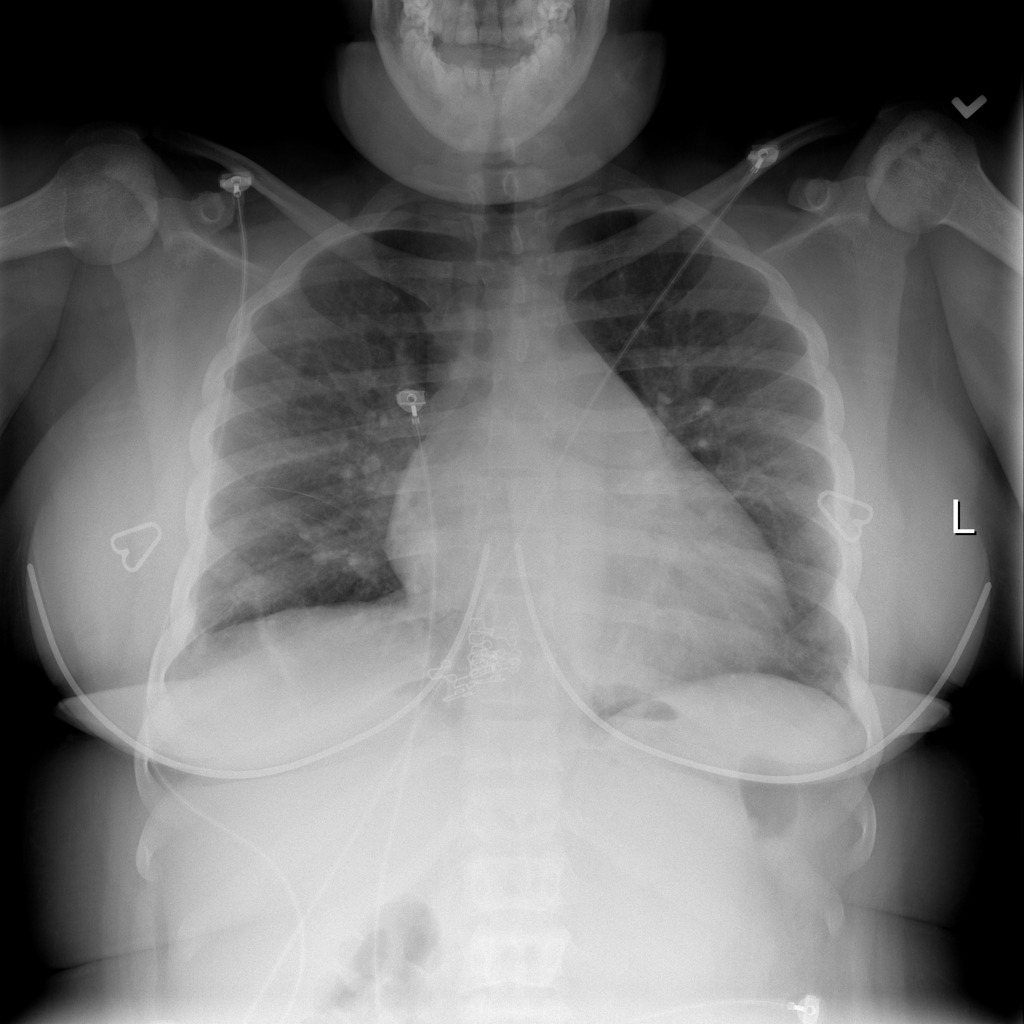

In [27]:
img = '6fe126b4-dbbd-4a44-b09c-7a992c8767e8.png'
image_display(com_path,img)

In [41]:
p = join_path(com_path,'train')
files = os.listdir(com_path)
len(files)

318

In [39]:
print(len(train_imgs))
print(len(valid_imgs))
#there seems to be 76 common files which are both on validation and training set
# all this is the cause of duplicate values in the patient records
# we're not going to handle the duplicates now but its better to remove
# duplicate values before in future 
len(set(train_imgs).intersection(valid_imgs))

3817
992


76

In [87]:
# train_imgs = common_files(com_path,X_train)
# valid_imgs = common_files(com_path,X_valid)

# # moving train files first
# move_files(com_path,train_imgs,'train')
# #moving valid files 
# move_files(com_path,valid_imgs,'valid')

As we're successful on moving files to the respective train and valid folder. Now, we are going to move the files into respective class folder.

Before that we've to do little bit of tasks as shown in the few cells below:

Note: Initially, there may be no files into the respective folder as files take time to move in the google drive(in colab it one of the factor it depends upon is your internet speed). So, bear with it and the files will show up in the folders.

If you're running the notebook for the first time, you should uncomment and run the following cells else you can run preceding cells. These comment cells are used to combine the original csv file of patient img with newly created patient record csv from image conversion process from dicom files.
And final dataFrame is written to csv file for future use.

In [46]:
# # 1.inner join the dataset of separated data with original dataset

# # read the file using pandas
# df = pd.read_csv(os.path.join(path,'patient_records.csv'))
# # rename the columns
# df.columns = ['patientId','sex','age']
# print(len(df))
# df.head()

In [47]:
# # remove the duplicate columns before merge
# df = df.drop_duplicates()
# labels_csv = labels_csv.drop_duplicates(subset='patientId')
# # inner join between df and label_csv
# temp_df = df.merge(labels_csv,on='patientId',how='inner')
# # write the resulted dataFrame into csv file for later use
# temp_df.to_csv(os.path.join(path,"patient_files.csv"),index=False)

In [48]:
# reading new csv file created from above cells
# path here is the main folder path where all the files 
# related to this project is situated
new_df = pd.read_csv(os.path.join(path,"patient_files.csv"))
new_df.head()

,patientId,sex,age,x,y,width,height,Target
0,b70a7d7e-3e11-4a74-998f-67eabfa438df,37,M,305.0,460.0,145.0,172.0,1
1,274f1a78-5887-4694-8fd6-a1847d9bc486,36,F,613.0,398.0,227.0,568.0,1
2,62829608-8d5e-4159-bcc6-366960fd1949,49,F,NaN,NaN,NaN,NaN,0
3,b6276787-bf66-4151-9f7a-b3d7fdf5ae30,33,M,636.0,260.0,262.0,205.0,1
4,8810a730-3f76-408d-ac9d-cef6e9629c89,42,M,205.0,238.0,290.0,592.0,1


In [49]:
# safe check before moving ahead after merge
print(len(new_df))
new_df['Target'].value_counts()

# there is less number of pnemonia cases as there was duplicate patient record
# which we didn't check before converting the images, case of imbalance  
# in the dataset

5049


0    2664
1    2385
Name: Target, dtype: int64

In [50]:
com_path

'drive/My Drive/Data/pneumonia-data/train'

In [58]:
# creating folder with number of classese and moving the files

# function move the files to respective class folder
def class_folder(path,classes,df):
  """"
  Function to move files to respective class folder

  Args:
    path: files path
    classes: array containing the classes
    df: dataFrame

  Returns:
    None
  """
  for c in classes:
    temp_df = df.loc[df['Target'] == c]
    #print(len(common_files(valid_path,df)))
    # using common_files method to list only the common files
    files = common_files(path,temp_df)
    # using move files method to move the files to class folder
    # wrapping the int c into str, as required
    move_files(path,files,str(c))
    #print(files[:10])

In [59]:
train_path = join_path(com_path,'train')
valid_path = join_path(com_path,'valid')
# classes 1:"pneumonia", 0:'normal'
classes = np.unique(y_train)

# moving the training files
class_folder(train_path,classes,new_df)
# moving validation files
class_folder(valid_path,classes,new_df)

directory created!!!
directory created!!!
directory created!!!
directory created!!!


In [ ]:
# a =[1,2,3,4,5,6,7,8,9]
# b = [3,5,7,9]
# # different elements between two list
# print(list(set(a).difference(b)))
# list(set(a).intersection(b))

[1, 2, 4, 6, 8]


[9, 3, 5, 7]

In [ ]:
# # take all the files name from train directory 
# # check which classes they belong from patient record files
# # and finally move to file to relevant folders

# # list of image files in the current directory
# #d = os.path.join(com_path,'valid')
# files = os.listdir(com_path)
# new_files = []
# # trying to remove the file extension for comparision
# for f in files:
#   new_files.append(f.split('.')[0])
# # series containing 
# # pnuemonia imgs
# p_list = new_df.loc[new_df['Target']==1,'patientId'].tolist()
# # noraml imgs
# n_list = new_df.loc[new_df['Target'] ==0, 'patientId'].tolist()

# # taking common images using set
# p_list = list(set(p_list).intersection(new_files))
# n_list = list(set(n_list).intersection(new_files))
# len(n_list),len(p_list)

(2586, 2385)

In [61]:
# calling the image generator function
train_gen, valid_gen = image_generator(train_path,valid_path)

Found 3817 images belonging to 2 classes.
Found 916 images belonging to 2 classes.


##### Building model (inspired by leNet-5 archtecture)

In [66]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Flatten 


n_classes =2

model = Sequential()

# first convolutional layer:
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',
                input_shape=(64,64,3)))

# second conv layer, with pooling and dropout:
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())

# dense hidden layer, with dropout:
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

# output layer:
# using unit=1 as output in binary
model.add(Dense(units=1,activation='softmax'))
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

We, have to resize the image before feed into NN cause its to large to fit in memory....

In [68]:
history = model.fit_generator(train_gen,
                    epochs=25,
                    validation_data=valid_gen)

Epoch 1/25
120/120 [==============================] - 63s 524ms/step - loss: 8.0008 - accuracy: 0.4771 - val_loss: 6.0997 - val_accuracy: 0.4585
Epoch 2/25
120/120 [==============================] - 57s 473ms/step - loss: 8.0110 - accuracy: 0.4771 - val_loss: 7.6246 - val_accuracy: 0.4585
Epoch 3/25
120/120 [==============================] - 57s 475ms/step - loss: 8.0211 - accuracy: 0.4771 - val_loss: 6.8622 - val_accuracy: 0.4585
Epoch 4/25
120/120 [==============================] - 56s 463ms/step - loss: 8.0110 - accuracy: 0.4771 - val_loss: 6.8622 - val_accuracy: 0.4585
Epoch 5/25
120/120 [==============================] - 56s 464ms/step - loss: 7.9907 - accuracy: 0.4771 - val_loss: 7.6246 - val_accuracy: 0.4585
Epoch 6/25
120/120 [==============================] - 56s 464ms/step - loss: 8.0211 - accuracy: 0.4771 - val_loss: 9.9120 - val_accuracy: 0.4585
Epoch 7/25
120/120 [==============================] - 55s 461ms/step - loss: 8.0110 - accuracy: 0.4771 - val_loss: 7.6246 - val_ac

In [81]:
import matplotlib.pyplot as plt
# function to plot the graph for trained model

def graph_trained_model(history,epochs):
  """
  Function to show to graph of the trained model for evaluation

  Args:
    history: dictionary containing model performace history
    epochs: number of iteration the model is trained on

  Returns:
    None
  """
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

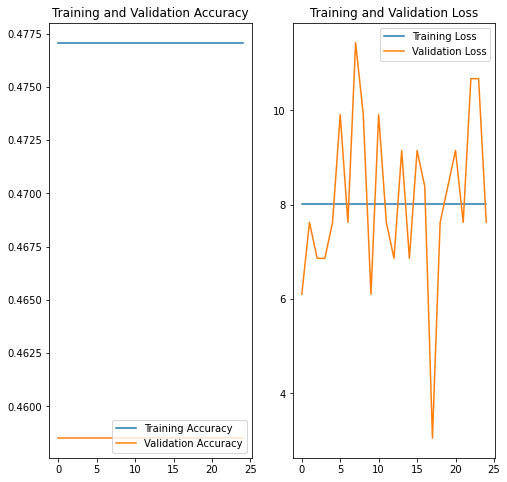

In [82]:
graph_trained_model(history,25)

The model inspired by LeNet architecture didn't perform well. As we can see the model was not able to learn from the graph(Straight line). So, we are to experiement with different architecture(modified the mode architecture) for model improvement.

#### Trying out another model architecture 

In [83]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [72]:
def model_create():
    model = Sequential()
    model.add(Convolution2D(32,(3,3),input_shape=(64,64,3),activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(units=128,activation='relu'))
    model.add(Dense(units=1,activation='sigmoid'))
    model.compile(optimizer ='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model = model_create()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               3936384   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 3,937,409
Trainable params: 3,937,409
Non-trainable params: 0
_________________________________________________________________


In [73]:
history1 = model.fit_generator(train_gen,
                    epochs=25,
                    validation_data=valid_gen)

Epoch 1/25
120/120 [==============================] - 62s 513ms/step - loss: 0.7331 - accuracy: 0.6453 - val_loss: 0.8837 - val_accuracy: 0.6910
Epoch 2/25
120/120 [==============================] - 56s 469ms/step - loss: 0.5542 - accuracy: 0.7286 - val_loss: 0.6904 - val_accuracy: 0.7271
Epoch 3/25
120/120 [==============================] - 56s 467ms/step - loss: 0.5534 - accuracy: 0.7218 - val_loss: 0.7759 - val_accuracy: 0.7205
Epoch 4/25
120/120 [==============================] - 56s 464ms/step - loss: 0.5468 - accuracy: 0.7286 - val_loss: 0.5137 - val_accuracy: 0.7293
Epoch 5/25
120/120 [==============================] - 56s 470ms/step - loss: 0.5411 - accuracy: 0.7312 - val_loss: 0.7760 - val_accuracy: 0.7140
Epoch 6/25
120/120 [==============================] - 55s 460ms/step - loss: 0.5436 - accuracy: 0.7291 - val_loss: 0.6226 - val_accuracy: 0.6932
Epoch 7/25
120/120 [==============================] - 55s 462ms/step - loss: 0.5302 - accuracy: 0.7417 - val_loss: 0.7406 - val_ac

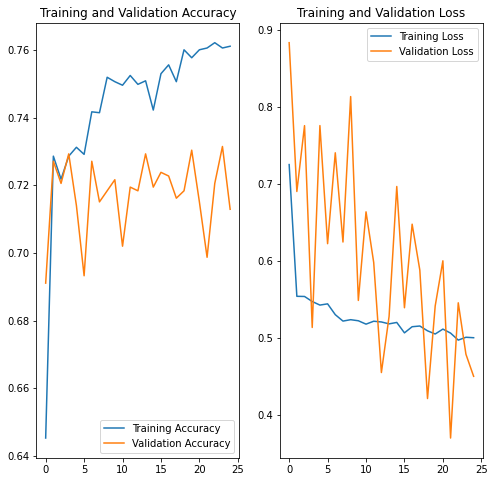

In [74]:
graph_trained_model(history1,25)

Graph shows there is gradual increase in the training accuracy but validaton loss is consistency. These is the case of neuron saturation or in other sense overfitting.

Note: Learning is very slow need to set the learning parameter inoder to check if any improvements can be done.

##### Trying our third model with added second layer in the second model

In [85]:
def model_create1():
    model = Sequential()
    model.add(Convolution2D(32,(3,3),input_shape=(64,64,3),activation='relu'))
    model.add(MaxPooling2D((2,2)))
    # adding dropout
    model.add(Dropout(0.25))

    # second layer
    model.add(Convolution2D(32,(3,3),input_shape=(64,64,3),activation='relu'))
    model.add(MaxPooling2D((2,2)))
    # adding dropout
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(units=128,activation='relu'))
    # adding dropout
    model.add(Dropout(0.5))
    model.add(Dense(units=1,activation='sigmoid'))
    model.compile(optimizer ='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model1 = model_create1()
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6272)             

In [86]:
history2 = model1.fit_generator(train_gen,
                    epochs=25,
                    validation_data=valid_gen)

Epoch 1/25
120/120 [==============================] - 64s 532ms/step - loss: 0.6357 - accuracy: 0.6269 - val_loss: 0.5610 - val_accuracy: 0.6779
Epoch 2/25
120/120 [==============================] - 57s 478ms/step - loss: 0.5740 - accuracy: 0.7121 - val_loss: 0.5586 - val_accuracy: 0.7194
Epoch 3/25
120/120 [==============================] - 57s 476ms/step - loss: 0.5552 - accuracy: 0.7226 - val_loss: 0.5450 - val_accuracy: 0.7107
Epoch 4/25
120/120 [==============================] - 57s 472ms/step - loss: 0.5520 - accuracy: 0.7299 - val_loss: 0.5943 - val_accuracy: 0.7151
Epoch 5/25
120/120 [==============================] - 57s 477ms/step - loss: 0.5368 - accuracy: 0.7422 - val_loss: 0.5987 - val_accuracy: 0.7205
Epoch 6/25
120/120 [==============================] - 56s 469ms/step - loss: 0.5367 - accuracy: 0.7325 - val_loss: 0.6780 - val_accuracy: 0.7129
Epoch 7/25
120/120 [==============================] - 55s 462ms/step - loss: 0.5354 - accuracy: 0.7414 - val_loss: 0.6619 - val_ac

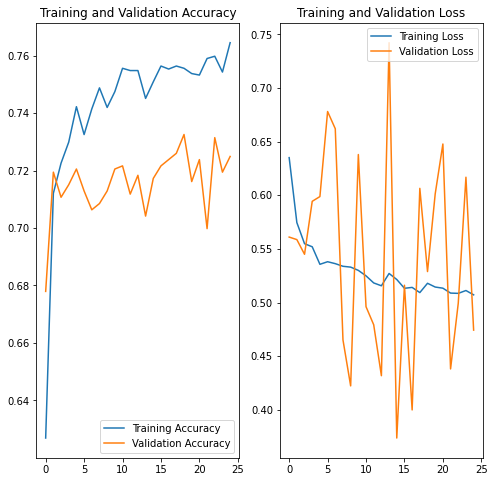

In [88]:
graph_trained_model(history2,25)

Only slight improve of approx. 1.2% improve from the second model with added second layer and dropouts. Dropout here is used for minimizing the overfitting of the model (dropping 25% to 50% neurons during training or other way those neurons are turned off while training.

Validation of 72.49% is not enough for the deployment purpose for Deep Learning model(that's what I think as traditional ML model can also achieve this with proper hyperparameter tunning). So, we'll be further exploring different techniques to improve the model efficiency.

For better performace model:
- Train with more data
- Optimization using the model hyperparameter: should look for the sweet spot every hyperparameter 
  - using more number of iteration i.e increase the number of epochs
  - play around with model architecture(adding or removing different layers)

- Using Transfer learning technique